<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

## <span id="section-0" style="color:#00B8DE"> 0 - Imports, Parameters, Functions </span>

In [220]:
import  warnings
import  phitter
import  numpy                                       as      np
import  matplotlib.pyplot                           as      plt
from    time                                        import  time
from    tqdm                                        import  tqdm
from    scipy.stats                                 import  norm, johnsonsu, johnsonsb, lognorm, kstest
from    scipy.special                               import  eval_genlaguerre
from    sklearn.linear_model                        import  LinearRegression
from    math                                        import  sqrt, exp
from    johnson_mm_fitting                          import  f_johnson_M
from    statsmodels.stats.diagnostic                import  normal_ad

np.random.seed(0)
plt.style.use('ggplot')

In [221]:
color_jlsmc     = 'blue'
color_glsmc     = 'red'
color_invalid   = 'purple'

In [222]:
# 1/24 = 1 week. 1Y = 6M | 1M = 4W --> 1Y = 24W
# 1/240 = 1/2 bday. 1W = 5 bdays
r, S0, sigma, T, delta, dt = 0.05, 100, 0.3, 1, 1/24, 1/240

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 100000
tref        = 0.3625 #0.3625 # 1/12 : 1 month 
ind_tref, ind_delta, ind_tdelta = int(tref/dt), int(delta/dt), int((tref+delta)/dt)
Sref        = 100 # 100
alpha       = 0.99
K           = 95
order_mom   = 4

jtypes_map      = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}
rev_jtypes_map  = {v: k for k, v in jtypes_map.items()}

In [223]:
def beta(t):
    return np.exp(-r*t)

def gen_S(S0, M, N):
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

def gen_mtm_put(S_paths, time_grid):
    M   = S_paths.shape[0]
    N   = S_paths.shape[1]-1
    mtm = np.zeros((M, N+1))
    for i in range(N+1):
        d1          = (np.log(S_paths[:, i]/K) + (r + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm[:, i]   = K*beta(T-time_grid[i])*norm.cdf(-d2) - S_paths[:, i]*norm.cdf(-d1)
        
    return mtm

def get_mu2(mu1raw, mu2raw):
    return mu2raw - mu1raw**2
def get_mu3(mu1raw, mu2raw, mu3raw):
    return mu3raw - 3*mu1raw*mu2raw - mu1raw**3
def get_mu4(mu1raw, mu2raw, mu3raw, mu4raw):
    return mu4raw - 4*mu1raw*mu3raw + 6*mu2raw*mu1raw**2 - 3*mu1raw**4
def get_centred_moms(mu1raw, mu2raw, mu3raw, mu4raw):
    mu2 = get_mu2(mu1raw, mu2raw)
    mu3 = get_mu3(mu1raw, mu2raw, mu3raw)
    mu4 = get_mu4(mu1raw, mu2raw, mu3raw, mu4raw)
    return mu2, mu3, mu4
def get_skew(mu3, mu2):
    return mu3 / mu2**(3/2)
def get_kurt(mu4, mu2):
    return mu4 / mu2**2

def regress_moms_jlsmc(mtm_train, y_train, mtm_pred_list):
    S_jlsmc = 2
    X_train = np.column_stack([eval_genlaguerre(s, 0, mtm_train) for s in range(S_jlsmc+1)])
    yhat_pred_list  = []
    X_pred_list     = []
    for mtm in mtm_pred_list:
        X_pred      = np.column_stack([eval_genlaguerre(s, 0, mtm) for s in range(S_jlsmc+1)])
        yhat_pred   = np.zeros((len(mtm), order_mom+1))
        X_pred_list.append(X_pred)
        yhat_pred_list.append(yhat_pred)
    for j in range(1, order_mom+1):
        model = LinearRegression(fit_intercept=False)
        model.fit(X_train, y_train[:, j-1])
        for i, mtm in enumerate(mtm_pred_list):
            yhat_pred_list[i][:, j-1] = model.predict(X_pred_list[i])

    return yhat_pred_list


def regress_moms_glsmc(mtm_train, y_train, mtm_pred_list):
    S_glsmc = 2
    X_train = np.column_stack([mtm_train**s for s in range(S_glsmc+1)])
    model   = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    yhat_pred_list = []
    for mtm in mtm_pred_list:
        X_pred          = np.column_stack([mtm**s for s in range(S_glsmc+1)])
        yhat_pred       = np.zeros((len(mtm), order_mom+1))
        yhat_pred[:, 1] = model.predict(X_pred)
        yhat_pred[:, 3] = 3*yhat_pred[:, 1]**2
        yhat_pred_list.append(yhat_pred)

    return yhat_pred_list


def get_moms_mask(yhat):
    mu1rawhat, mu2rawhat, mu3rawhat, mu4rawhat = yhat[:, 0], yhat[:, 1], yhat[:, 2], yhat[:, 3]
    mu2hat, mu3hat, mu4hat  = get_centred_moms(mu1rawhat, mu2rawhat, mu3rawhat, mu4rawhat)
    skewhat                 = get_skew(mu3hat, mu2hat)
    kurthat                 = get_kurt(mu4hat, mu2hat)

    mask_mu2hat     = (mu2rawhat>0)&(mu2hat>0)
    mask_mu3hat     = (mu2rawhat>0)
    mask_mu4hat     = (mu4rawhat>0)&(mu2rawhat>0)&(mu4hat>0)
    mask_skewhat    = (mask_mu3hat)&(mask_mu2hat)
    mask_kurthat    = (mask_mu4hat)&(mask_mu2hat)
    mask_tothat     = (mask_skewhat)&(mask_kurthat)
    
    return mu1rawhat, mu2rawhat, mu3rawhat, mu4rawhat, mu2hat, mu3hat, mu4hat, skewhat, kurthat, mask_mu2hat, mask_mu3hat, mask_mu4hat, mask_skewhat, mask_kurthat, mask_tothat


def fit_johnson(mu1rawhat, mu2hat, skewhat, kurthat, mask_tothat, PRINT_MESS=True):
    jparamshat = np.zeros((len(mu1rawhat), 4))
    jtypehat   = np.zeros(len(mu1rawhat))
    mask_hat_jlsmc = np.zeros_like(mu1rawhat, dtype=bool)
    for i in range(len(mu1rawhat)):
        if mask_tothat[i]:
            jcoeffs, jf, mess = f_johnson_M(mu1rawhat[i], sqrt(mu2hat[i]), skewhat[i], kurthat[i])
            if mess == '(b2 < b1+one)': 
                if PRINT_MESS:
                    print(f'Warning: impossible region for support point n°{i} ({jf}): beta2 = {kurthat[i]:.2f} < beta1+1 = {skewhat[i]**2+1:.2f}')
                jparamshat[i]  = np.repeat(np.nan, 4)
                jtypehat[i]    = None
            else:
                if np.any(np.isnan(jcoeffs)):
                    if PRINT_MESS:
                        print(f'Warning: NaN coefficients for support point n°{i}')
                        print(f'    (mu1, mu2, skew, kurt)      = ({mu1rawhat[i]:.2f}, {mu2hat[i]:.2f}, {skewhat[i]:.2f}, {kurthat[i]:.2f})')
                        print(f'    (gamma, delta, xi, lambda)  = ({jcoeffs[0]:.2f}, {jcoeffs[1]:.2f}, {jcoeffs[2]:.2f}, {jcoeffs[3]:.2f})')
                    jparamshat[i] = np.repeat(np.nan, 4)
                    jtypehat[i]    = None
                else:
                    mask_hat_jlsmc[i] = True
                    jparamshat[i] = jcoeffs
                    jtypehat[i]   = jtypes_map[jf]
                    '''
                    if jf == 'SL':
                        print(jcoeffs)
                        print(skewhat[i])
                    '''
    return jparamshat, jtypehat, mask_hat_jlsmc


def quantile_johnson(jparamshat, jtypehat, alpha, mtmdiff_pdf=None):
    quanthat    = np.zeros((jparamshat.shape[0], len(alpha)))
    maskhat     = np.ones_like(quanthat, dtype=bool)
    if mtmdiff_pdf is not None:
        pdfhat = np.zeros((len(quanthat), len(mtmdiff_pdf)))
    for i in range(jparamshat.shape[0]):
        gamma_, delta_, xi_, lambda_    = jparamshat[i:i+1, 0], jparamshat[i:i+1, 1], jparamshat[i:i+1, 2], jparamshat[i:i+1, 3]
        absdelta_, abslambda_           = np.abs(delta_), np.abs(lambda_)
        if jtypehat[i] == 1:
            quanthat[i]     = lognorm.ppf(alpha, s=1/absdelta_, loc=xi_, scale=lambda_*exp(-gamma_/delta_))
            if mtmdiff_pdf is not None:
                pdfhat[i, :] = lognorm.pdf(mtmdiff_pdf, s=1/absdelta_[0], loc=xi_[0], scale=lambda_[0]*exp(-gamma_[0]/delta_[0]))
        elif jtypehat[i] == 2:
            quanthat[i] = johnsonsu.ppf(alpha, a=gamma_, b=delta_, loc=xi_, scale=lambda_)
            if mtmdiff_pdf is not None:
                pdfhat[i, :] = johnsonsu.pdf(mtmdiff_pdf, a=gamma_[0], b=delta_[0], loc=xi_[0], scale=lambda_[0])
        elif (jtypehat[i]==3) or (jtypehat[i]==5):
            quanthat[i] = johnsonsb.ppf(alpha, a=gamma_, b=delta_, loc=xi_, scale=lambda_)
            if mtmdiff_pdf is not None:
                pdfhat[i, :] = johnsonsb.pdf(mtmdiff_pdf, a=gamma_[0], b=delta_[0], loc=xi_[0], scale=lambda_[0])
        elif jtypehat[i] == 4:
            quanthat[i] = norm.ppf(alpha, loc=(xi_-gamma_*lambda_)/delta_, scale=abslambda_/absdelta_)
            if mtmdiff_pdf is not None:
                pdfhat[i, :] = norm.pdf(mtmdiff_pdf, loc=(xi_[0]-gamma_[0]*lambda_[0])/delta_[0], scale=abslambda_[0]/absdelta_[0])
        maskhat[i, :] = np.isfinite(quanthat[i])
    if mtmdiff_pdf is not None:
        return quanthat, maskhat, pdfhat
    return quanthat, maskhat


def quantile_gaussian(mu2hat, alpha, mtmdiff_pdf=None):
    quanthat  = norm.ppf(alpha, loc=0, scale=np.sqrt(mu2hat.reshape(-1, 1)))
    if mtmdiff_pdf is not None:
        pdfhat = norm.pdf(mtmdiff_pdf, loc=0, scale=np.sqrt(mu2hat.reshape(-1, 1)))
        return quanthat, pdfhat
    return quanthat


def get_var_jlsmc(R, mtm_supp, quanthat_supp, mtm_pred_list):
    X_train = np.column_stack([eval_genlaguerre(r, 0, mtm_supp) for r in range(R+1)])
    model   = LinearRegression(fit_intercept=False)
    model.fit(X_train, quanthat_supp)
    yhat_pred_list  = []
    for mtm in mtm_pred_list:
        X_pred = np.column_stack([eval_genlaguerre(r, 0, mtm) for r in range(R+1)])
        yhat_pred_list.append(model.predict(X_pred))

    return yhat_pred_list


def get_moms_nmc(M_in, S, ind_tref):
    M                   = S.shape[0]
    S_paths_nested      = np.zeros((M, M_in, ind_delta+1))
    mtm_paths_nested    = np.zeros((M, M_in, ind_delta+1))
    mtmdiff             = np.zeros((M, M_in))
    for m in range(M):
        S_paths_nested[m, :, :]     = gen_S(S[m], M_in, ind_delta)
        mtm_paths_nested[m, :, :]   = gen_mtm_put(S_paths_nested[m, :, :], time_grid[ind_tref:ind_tref+ind_delta+1])
        mtmdiff[m, :]               = mtm_paths_nested[m, :, -1] - mtm_paths_nested[m, :, 0]
    
    mu1raw = np.mean(mtmdiff, axis=1)
    mu2raw = np.mean(mtmdiff**2, axis=1)
    mu3raw = np.mean(mtmdiff**3, axis=1)
    mu4raw = np.mean(mtmdiff**4, axis=1)
    mu2, mu3, mu4 = get_mu2(mu1raw, mu2raw), get_mu3(mu1raw, mu2raw, mu3raw), get_mu4(mu1raw, mu2raw, mu3raw, mu4raw)
    skew     = get_skew(mu3, mu2)
    kurt     = get_kurt(mu4, mu2)

    return mtm_paths_nested, mtmdiff, mu1raw, mu2raw, mu3raw, mu4raw, mu2, mu3, mu4, skew, kurt


def gen_var_put(S, mtm):
    var_S   = S * exp((r-0.5*sigma**2)*delta + sigma*sqrt(delta)*norm.ppf(1-alpha))
    temp    = gen_mtm_put(var_S.reshape(-1, 1), time_grid[ind_tdelta:ind_tdelta+1]).reshape(-1)
    varhat  = temp - mtm
    return varhat

## <span id="section-1" style="color:#00B8DE"> I - Risk Factors & Portfolio Paths </span>

In [224]:
S_paths         = gen_S(S0, M, N)
S_train         = S_paths[:, ind_tref]
mtm_paths       = gen_mtm_put(S_paths, time_grid)
mtmdiff_paths   = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]
mtm_train       = mtm_paths[:, ind_tref]

mtm_ref         = gen_mtm_put(np.array([[Sref]]), time_grid[ind_tref:ind_tref+1])[0]

mtm_func        = np.linspace(np.min(mtm_train), np.max(mtm_train), 1000)

Nq          = 100
Nqtail      = int(0.1*Nq)//2
q_main      = np.arange(1, Nq) / Nq
q_ltail     = np.linspace(0, 0.01, Nqtail+2)[1:-1]
q_utail     = np.linspace(0.99, 1, Nqtail+2)[1:-1]
q_all       = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))
mtm_supp    = np.quantile(mtm_train, q_all, method='inverted_cdf')

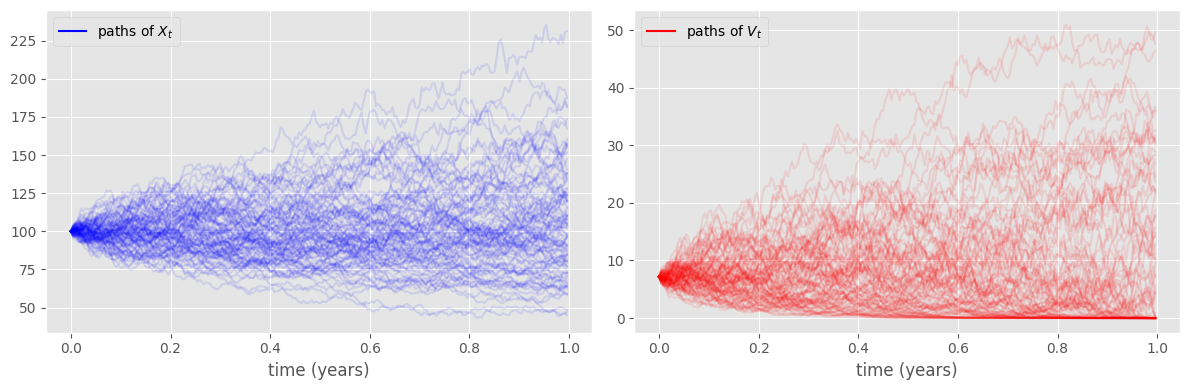

In [225]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(time_grid, S_paths[:100, :].T, color='blue', alpha=0.1)
axs[0].plot([None], [None], color='blue', label='paths of $X_t$')
axs[0].set_xlabel('time (years)')
axs[0].legend(loc='upper left')

axs[1].plot(time_grid, mtm_paths[:100, :].T, color='red', alpha=0.1)
axs[1].plot([None], [None], color='red', label='paths of $V_t$')
axs[1].set_xlabel('time (years)')
axs[1].legend(loc='upper left')

plt.tight_layout()
# plt.savefig(f'figures/riskfact_port_paths.png', bbox_inches='tight', dpi=300)
plt.show()

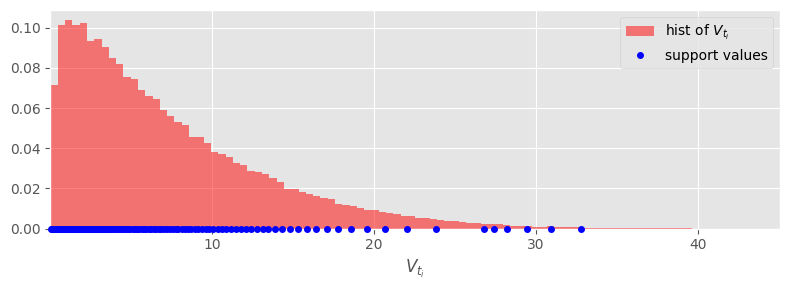

In [226]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(mtm_train, bins=100, density=True, alpha=0.5, color='red', label='hist of $V_{t_i}$')
ax.plot(mtm_supp, np.zeros_like(mtm_supp), 'o', color=color_jlsmc, label='support values', clip_on=False, zorder=10, markersize=4)
ax.set_xlabel('$V_{t_i}$')
ax.set_xlim(np.min(mtm_train), np.max(mtm_train))
ax.legend()
plt.tight_layout()
# plt.savefig(f'figures/support_vals.png', bbox_inches='tight', dpi=300)
plt.show()

In [227]:
Mtest       = 100
Mtest_in    = 100000
S_test      = np.linspace(np.min(S_paths[:, ind_tref]), np.max(S_paths[:, ind_tref]), Mtest)
mtm_test_paths_nested, mtmdiff_test, mu1raw_test, mu2raw_test, mu3raw_test, mu4raw_test, mu2_test, mu3_test, mu4_test, skew_test, kurt_test = get_moms_nmc(Mtest_in, S_test, ind_tref)
mtm_test    = mtm_test_paths_nested[:, 0, 0]

Mref_in     = 100000
mtm_ref_paths_nested, mtmdiff_ref, mu1raw_ref, mu2raw_ref, mu3raw_ref, mu4raw_ref, mu2_ref, mu3_ref, mu4_ref, skew_ref, kurt_ref = get_moms_nmc(Mref_in, np.array([Sref]), ind_tref)
quant_ref   = np.quantile(mtmdiff_ref[0, :], alpha, method='inverted_cdf')

Mcomp       = 100
Mcomp_in    = 100000
bin_size    = M//Mcomp
sorted_inds = np.argsort(mtm_train)
selec_inds  = np.array([sorted_inds[i*bin_size + bin_size//2] for i in range(Mcomp)])
S_comp      = S_paths[selec_inds, ind_tref]
mtm_comp_paths_nested, mtmdiff_comp, mu1raw_comp, mu2raw_comp, mu3raw_comp, mu4raw_comp, mu2_comp, mu3_comp, mu4_comp, skew_comp, kurt_comp = get_moms_nmc(Mcomp_in, S_comp, ind_tref)
mtm_comp     = mtm_comp_paths_nested[:, 0, 0]
quant_comp   = np.quantile(mtmdiff_comp, alpha, method='inverted_cdf', axis=1)

## <span id="section-2" style="color:#00B8DE"> II - Moments Regression </span>

In [228]:
mtm_pred_list_jlsmc = [mtm_test, mtm_func, mtm_supp, mtm_ref]
mtm_pred_list_glsmc = [mtm_test, mtm_func, mtm_ref, mtm_comp]
y_train_jlsmc = mtmdiff_paths[:, ind_tref:ind_tref+1]**np.arange(1, order_mom+1)
y_train_glsmc = mtmdiff_paths[:, ind_tref]**2

yhat_pred_list_jlsmc = regress_moms_jlsmc(mtm_train, y_train_jlsmc, mtm_pred_list_jlsmc)
yhat_pred_list_glsmc = regress_moms_glsmc(mtm_train, y_train_glsmc, mtm_pred_list_glsmc)

mu1rawhat_test_jlsmc, mu2rawhat_test_jlsmc, mu3rawhat_test_jlsmc, mu4rawhat_test_jlsmc, mu2hat_test_jlsmc, mu3hat_test_jlsmc, mu4hat_test_jlsmc, skewhat_test_jlsmc, kurthat_test_jlsmc, mask_mu2hat_test_jlsmc, mask_mu3hat_test_jlsmc, mask_mu4hat_test_jlsmc, mask_skewhat_test_jlsmc, mask_kurthat_test_jlsmc, mask_tothat_test_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[0])
mu1rawhat_func_jlsmc, mu2rawhat_func_jlsmc, mu3rawhat_func_jlsmc, mu4rawhat_func_jlsmc, mu2hat_func_jlsmc, mu3hat_func_jlsmc, mu4hat_func_jlsmc, skewhat_func_jlsmc, kurthat_func_jlsmc, mask_mu2hat_func_jlsmc, mask_mu3hat_func_jlsmc, mask_mu4hat_func_jlsmc, mask_skewhat_func_jlsmc, mask_kurthat_func_jlsmc, mask_tothat_func_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[1])
mu1rawhat_supp_jlsmc, mu2rawhat_supp_jlsmc, mu3rawhat_supp_jlsmc, mu4rawhat_supp_jlsmc, mu2hat_supp_jlsmc, mu3hat_supp_jlsmc, mu4hat_supp_jlsmc, skewhat_supp_jlsmc, kurthat_supp_jlsmc, mask_mu2hat_supp_jlsmc, mask_mu3hat_supp_jlsmc, mask_mu4hat_supp_jlsmc, mask_skewhat_supp_jlsmc, mask_kurthat_supp_jlsmc, mask_tothat_supp_jlsmc = get_moms_mask(yhat_pred_list_jlsmc[2])
mu1rawhat_ref_jlsmc, mu2rawhat_ref_jlsmc, mu3rawhat_ref_jlsmc, mu4rawhat_ref_jlsmc, mu2hat_ref_jlsmc, mu3hat_ref_jlsmc, mu4hat_ref_jlsmc, skewhat_ref_jlsmc, kurthat_ref_jlsmc, mask_mu2hat_ref_jlsmc, mask_mu3hat_ref_jlsmc, mask_mu4hat_ref_jlsmc, mask_skewhat_ref_jlsmc, mask_kurthat_ref_jlsmc, mask_tothat_ref_jlsmc                = get_moms_mask(yhat_pred_list_jlsmc[3])
mu1rawhat_test_glsmc, mu2rawhat_test_glsmc, mu3rawhat_test_glsmc, mu4rawhat_test_glsmc, mu2hat_test_glsmc, mu3hat_test_glsmc, mu4hat_test_glsmc, skewhat_test_glsmc, kurthat_test_glsmc, mask_mu2hat_test_glsmc, mask_mu3hat_test_glsmc, mask_mu4hat_test_glsmc, mask_skewhat_test_glsmc, mask_kurthat_test_glsmc, mask_tothat_test_glsmc = get_moms_mask(yhat_pred_list_glsmc[0])
mu1rawhat_func_glsmc, mu2rawhat_func_glsmc, mu3rawhat_func_glsmc, mu4rawhat_func_glsmc, mu2hat_func_glsmc, mu3hat_func_glsmc, mu4hat_func_glsmc, skewhat_func_glsmc, kurthat_func_glsmc, mask_mu2hat_func_glsmc, mask_mu3hat_func_glsmc, mask_mu4hat_func_glsmc, mask_skewhat_func_glsmc, mask_kurthat_func_glsmc, mask_tothat_func_glsmc = get_moms_mask(yhat_pred_list_glsmc[1])
mu1rawhat_ref_glsmc, mu2rawhat_ref_glsmc, mu3rawhat_ref_glsmc, mu4rawhat_ref_glsmc, mu2hat_ref_glsmc, mu3hat_ref_glsmc, mu4hat_ref_glsmc, skewhat_ref_glsmc, kurthat_ref_glsmc, mask_mu2hat_ref_glsmc, mask_mu3hat_ref_glsmc, mask_mu4hat_ref_glsmc, mask_skewhat_ref_glsmc, mask_kurthat_ref_glsmc, mask_tothat_ref_glsmc                = get_moms_mask(yhat_pred_list_glsmc[2])
mu1rawhat_comp_glsmc, mu2rawhat_comp_glsmc, mu3rawhat_comp_glsmc, mu4rawhat_comp_glsmc, mu2hat_comp_glsmc, mu3hat_comp_glsmc, mu4hat_comp_glsmc, skewhat_comp_glsmc, kurthat_comp_glsmc, mask_mu2hat_comp_glsmc, mask_mu3hat_comp_glsmc, mask_mu4hat_comp_glsmc, mask_skewhat_comp_glsmc, mask_kurthat_comp_glsmc, mask_tothat_comp_glsmc = get_moms_mask(yhat_pred_list_glsmc[3])

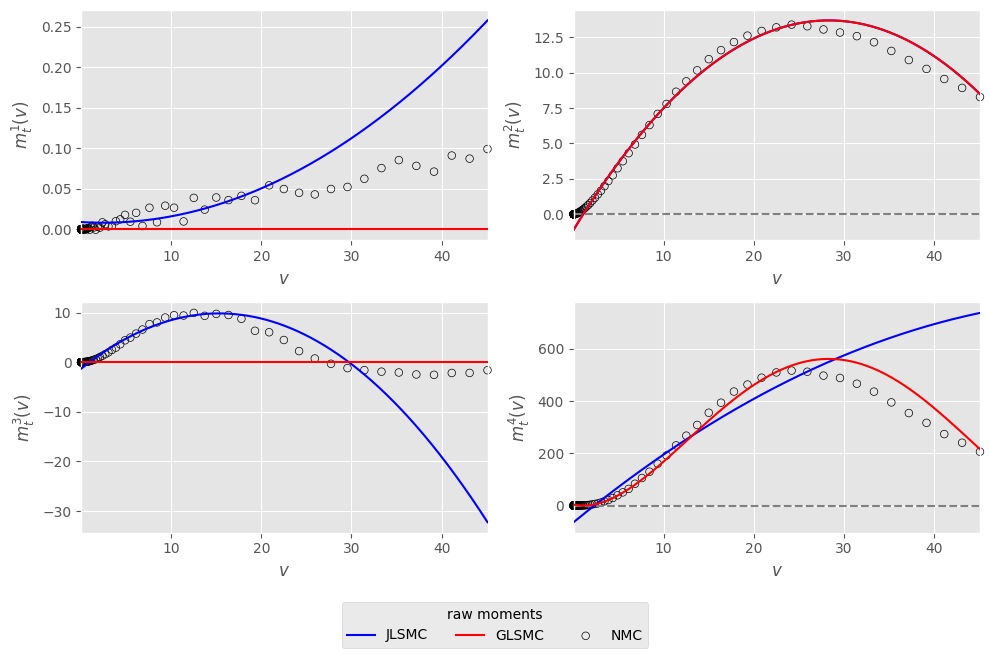

In [229]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(mtm_func, mu1rawhat_func_jlsmc, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0, 0].plot(mtm_func, mu1rawhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3)
axs[0, 0].scatter(mtm_test, mu1raw_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
# axs[0, 0].scatter(mtm_train, mtmdiff_paths[:, ind_tref], color='grey', s=10, alpha=0.5, label='train', clip_on=False, zorder=1)
axs[0, 0].set_xlabel('$v$')
axs[0, 0].set_ylabel('$m_t^1(v)$')
axs[0, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[0, 1].plot(mtm_func, mu2rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[0, 1].plot(mtm_func, mu2rawhat_func_glsmc, color=color_glsmc, zorder=3)
axs[0, 1].scatter(mtm_test, mu2raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
# axs[0, 1].scatter(mtm_train, mtmdiff_paths[:, ind_tref]**2, color='grey', s=10, alpha=0.5, clip_on=False, zorder=1)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].set_xlabel('$v$')
axs[0, 1].set_ylabel('$m_t^2(v)$')
axs[0, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 0].plot(mtm_func, mu3rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[1, 0].plot(mtm_func, mu3rawhat_func_glsmc, color=color_glsmc, zorder=3)
axs[1, 0].scatter(mtm_test, mu3raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
# axs[1, 0].scatter(mtm_train, mtmdiff_paths[:, ind_tref]**3, color='grey', s=10, alpha=0.5, clip_on=False, zorder=1)
axs[1, 0].set_xlabel('$v$')
axs[1, 0].set_ylabel('$m_t^3(v)$')
axs[1, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 1].plot(mtm_func, mu4rawhat_func_jlsmc, color=color_jlsmc, zorder=3)
axs[1, 1].plot(mtm_func, mu4rawhat_func_glsmc, color=color_glsmc, zorder=3)
axs[1, 1].scatter(mtm_test, mu4raw_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
# axs[1, 1].scatter(mtm_train, mtmdiff_paths[:, ind_tref]**4, color='grey', s=10, alpha=0.5, clip_on=False, zorder=1)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].set_xlabel('$v$')
axs[1, 1].set_ylabel('$m_t^4(v)$')
axs[1, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='raw moments')

plt.tight_layout()
#plt.savefig(f'figures/raw_moms.png', bbox_inches='tight', dpi=300)
plt.show()

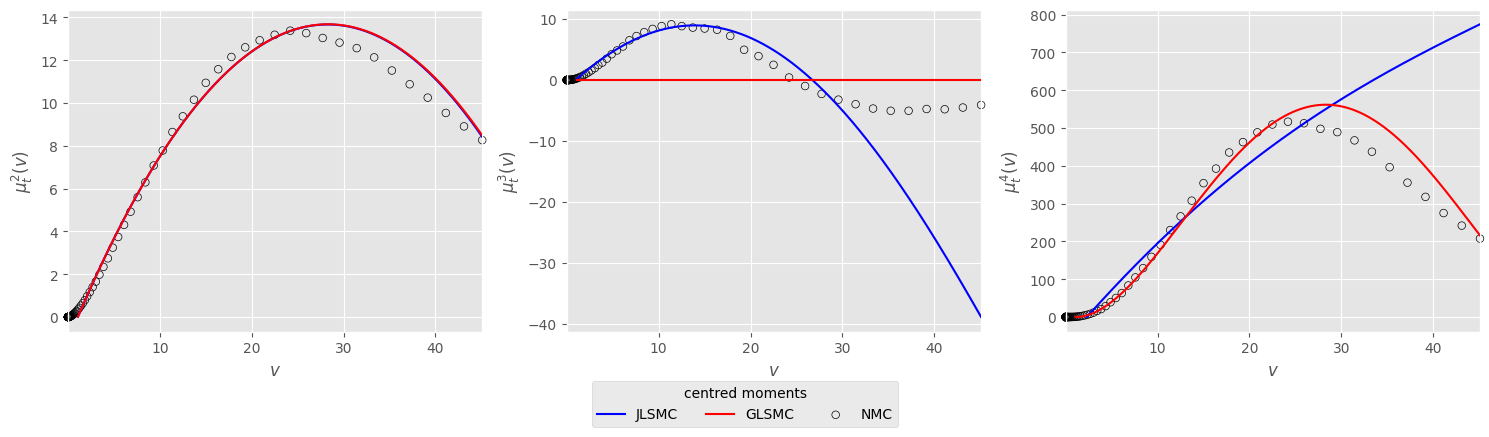

In [230]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(mtm_func[mask_mu2hat_func_jlsmc], mu2hat_func_jlsmc[mask_mu2hat_func_jlsmc], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot(mtm_func[mask_mu2hat_func_glsmc], mu2hat_func_glsmc[mask_mu2hat_func_glsmc], color=color_glsmc, label='GLSMC', zorder=3)
axs[0].scatter(mtm_test, mu2_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\mu_t^2(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_mu3hat_func_jlsmc], mu3hat_func_jlsmc[mask_mu3hat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].plot(mtm_func[mask_mu3hat_func_glsmc], mu3hat_func_glsmc[mask_mu3hat_func_glsmc], color=color_glsmc, zorder=3)
axs[1].scatter(mtm_test, mu3_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\mu_t^3(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_mu4hat_func_jlsmc], mu4hat_func_jlsmc[mask_mu4hat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[2].plot(mtm_func[mask_mu4hat_func_glsmc], mu4hat_func_glsmc[mask_mu4hat_func_glsmc], color=color_glsmc, zorder=3)
axs[2].scatter(mtm_test, mu4_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\mu_t^4(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='centred moments')

plt.tight_layout()
# plt.savefig(f'figures/centred_moms.png', bbox_inches='tight', dpi=300)
plt.show()

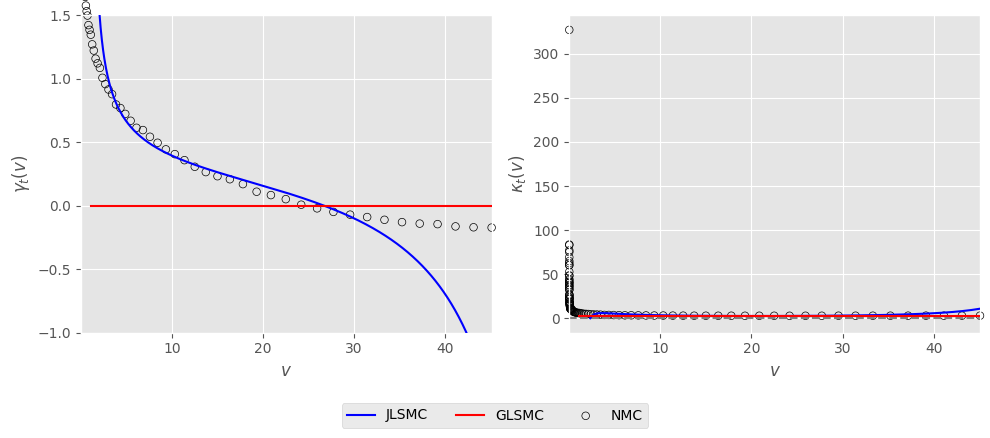

In [231]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_skewhat_func_jlsmc], skewhat_func_jlsmc[mask_skewhat_func_jlsmc], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot(mtm_func[mask_skewhat_func_glsmc], skewhat_func_glsmc[mask_skewhat_func_glsmc], color=color_glsmc, label='GLSMC', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1, top=1.5)

axs[1].plot(mtm_func[mask_kurthat_func_jlsmc], kurthat_func_jlsmc[mask_kurthat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].plot(mtm_func[mask_kurthat_func_glsmc], kurthat_func_glsmc[mask_kurthat_func_glsmc], color=color_glsmc, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].axhline(0, color='grey', linestyle='--')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
# plt.savefig(f'figures/skew_kurt.png', bbox_inches='tight', dpi=300)
plt.show()

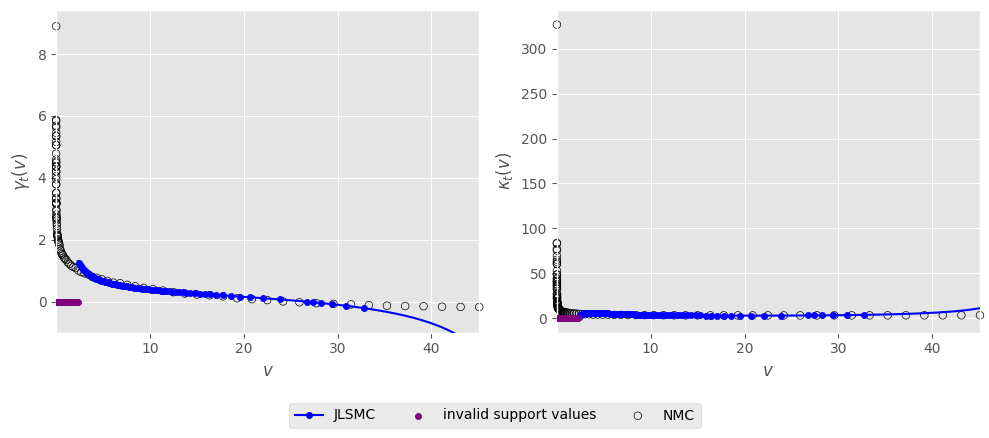

In [232]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_tothat_func_jlsmc], skewhat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp_jlsmc], skewhat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1)

axs[1].plot(mtm_func[mask_tothat_func_jlsmc], kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp_jlsmc], kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp_jlsmc], np.zeros_like(mtm_supp[~mask_tothat_supp_jlsmc]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
# plt.savefig(f'figures/skew_kurt_support.png', bbox_inches='tight', dpi=300)
plt.show()

## <span id="section-3" style="color:#00B8DE"> III - Johnson Moment Fitting </span>

In [233]:
warnings.filterwarnings('ignore')

jparamshat_supp, jtypehat_supp, mask_hat_supp_jlsmc   = fit_johnson(mu1rawhat_supp_jlsmc, mu2hat_supp_jlsmc, skewhat_supp_jlsmc, kurthat_supp_jlsmc, mask_tothat_supp_jlsmc)
jparamshat_ref, jtypehat_ref, mask_hat_ref_jlsmc      = fit_johnson(mu1rawhat_ref_jlsmc, mu2hat_ref_jlsmc, skewhat_ref_jlsmc, kurthat_ref_jlsmc, mask_tothat_ref_jlsmc)

In [234]:
jparamshat_supp.shape

(109, 4)

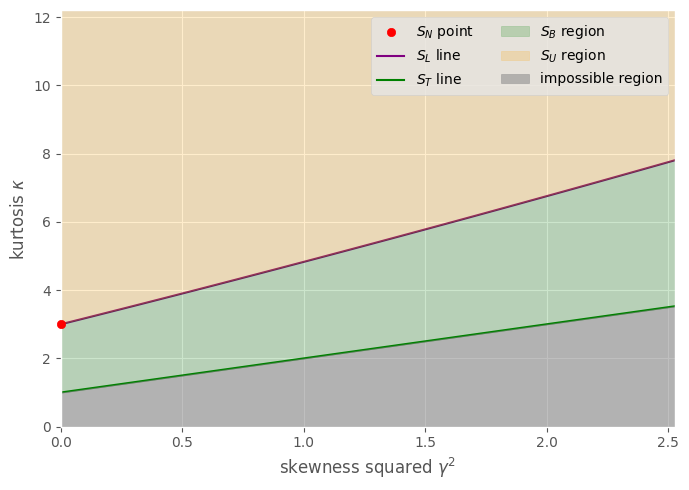

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter([0], [3], color=color_glsmc, label='$S_N$ point', zorder=3, clip_on=False)

omega       = np.linspace(1, 1.4, 100)
beta1_sl    = (omega-1) * (omega+2)**2
kurt_sl     = omega**4 + 2*omega**3 + 3*omega**2 - 3
ax.plot(beta1_sl, kurt_sl, color='purple', label='$S_L$ line', zorder=1)
kurt_lim    = 1 + beta1_sl
ax.plot(beta1_sl, kurt_lim, color='green', label='$S_T$ line', zorder=1)
ax.fill_between(beta1_sl, kurt_lim, kurt_sl, color='green', alpha=0.2, label='$S_B$ region', zorder=1)

max_kurt = max(np.max(kurthat_func_jlsmc[mask_tothat_func_jlsmc]), np.max(kurthat_func_glsmc[mask_tothat_func_jlsmc]), np.max(kurt_sl), np.max(kurt_lim))
ax.fill_between(beta1_sl, kurt_sl, max_kurt*np.ones_like(kurt_sl), color='orange', alpha=0.2, label='$S_U$ region', zorder=1)
beta1_lim   = np.linspace(np.min(skewhat_func_jlsmc[mask_tothat_func_jlsmc]**2), np.max(skewhat_func_jlsmc[mask_tothat_func_jlsmc]**2), 100)
kurt_lim2   = 1 + beta1_lim
ax.fill_between(beta1_lim, kurt_lim2, np.zeros_like(kurt_lim2), color='grey', alpha=0.5, label='impossible region', zorder=1)

ax.set_xlabel('skewness squared $\\gamma^2$')
ax.set_ylabel('kurtosis $\\kappa$')
ax.set_xlim(0, np.max(beta1_lim))
ax.set_ylim(0, max_kurt)
ax.legend(ncol=2)
plt.tight_layout()
# plt.savefig(f'figures/jfunc_plan.png', bbox_inches='tight', dpi=300)
plt.show()

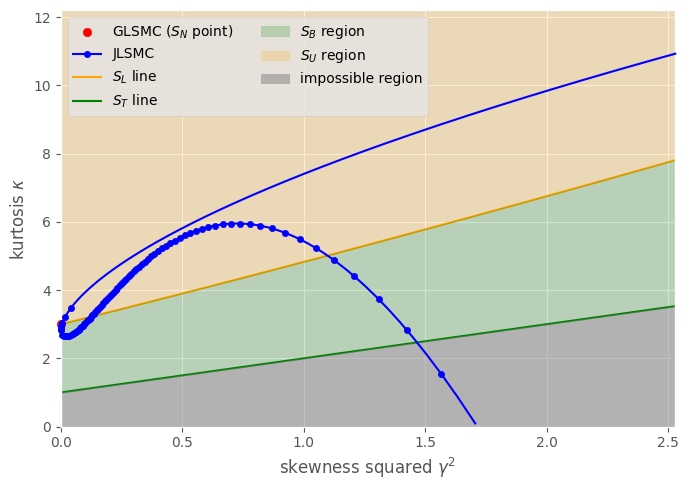

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter([0], [3], color=color_glsmc, label='GLSMC ($S_N$ point)', zorder=3, clip_on=False)
ax.plot(skewhat_func_jlsmc[mask_tothat_func_jlsmc]**2, kurthat_func_jlsmc[mask_tothat_func_jlsmc], color=color_jlsmc, zorder=3, clip_on=False)
ax.scatter(skewhat_supp_jlsmc[mask_tothat_supp_jlsmc]**2, kurthat_supp_jlsmc[mask_tothat_supp_jlsmc], color=color_jlsmc, s=20, zorder=3, clip_on=False)
ax.plot([None], [None], color=color_jlsmc, marker='o', markersize=4, label='JLSMC')
ax.plot(beta1_sl, kurt_sl, color='orange', label='$S_L$ line', zorder=1)
ax.plot(beta1_sl, kurt_lim, color='green', label='$S_T$ line', zorder=1)
ax.fill_between(beta1_sl, kurt_lim, kurt_sl, color='green', alpha=0.2, label='$S_B$ region', zorder=1)
ax.fill_between(beta1_sl, kurt_sl, max_kurt*np.ones_like(kurt_sl), color='orange', alpha=0.2, label='$S_U$ region', zorder=1)
ax.fill_between(beta1_lim, kurt_lim2, np.zeros_like(kurt_lim2), color='grey', alpha=0.5, label='impossible region', zorder=1)

ax.set_xlabel('skewness squared $\\gamma^2$')
ax.set_ylabel('kurtosis $\\kappa$')
ax.set_xlim(0, np.max(beta1_lim))
ax.set_ylim(0, max_kurt)
ax.legend(ncol=2)
plt.tight_layout()
# plt.savefig(f'figures/jfunc_plan_support.png', bbox_inches='tight', dpi=300)
plt.show()

## <span id="section-4" style="color:#00B8DE"> IV - Value-at-Risk Regression </span>

In [237]:
print(f'Number of invalid support points: {np.sum(~mask_hat_supp_jlsmc)}')

jparamshat_supp, jtypehat_supp, mtm_supp = jparamshat_supp[mask_hat_supp_jlsmc], jtypehat_supp[mask_hat_supp_jlsmc], mtm_supp[mask_hat_supp_jlsmc]
jparamshat_ref, jtypehat_ref, mtm_ref    = jparamshat_ref[mask_hat_ref_jlsmc], jtypehat_ref[mask_hat_ref_jlsmc], mtm_ref[mask_hat_ref_jlsmc]

quanthat_supp_jlsmc, mask_hat_supp_johnson                  = quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([alpha]))
mtmdiff_pdf_ref                                             = np.linspace(np.min(mtmdiff_ref), np.max(mtmdiff_ref), 1000)
quanthat_ref_jlsmc, mask_hat_ref_johnson, pdfhat_ref_jlsmc  = quantile_johnson(jparamshat_ref, jtypehat_ref, np.array([alpha]), mtmdiff_pdf_ref)
quanthat_ref_glsmc, pdfhat_ref_glsmc                        = quantile_gaussian(mu2hat_ref_glsmc, alpha, mtmdiff_pdf_ref)

Number of invalid support points: 28


In [238]:
mtm_supp            = mtm_supp[mask_hat_supp_johnson.reshape(-1)]
quanthat_supp_jlsmc = quanthat_supp_jlsmc[mask_hat_supp_johnson]

print(f'Number of invalid support points: {np.sum(~mask_hat_supp_jlsmc) + np.sum(~mask_hat_supp_johnson)}')

Number of invalid support points: 28


In [239]:
R_jlsmc                 = 2
varhat_pred_list_jlsmc  = get_var_jlsmc(R_jlsmc, mtm_supp, quanthat_supp_jlsmc, [mtm_func, mtm_comp])
varhat_func_jlsmc       = varhat_pred_list_jlsmc[0]
varhat_comp_jlsmc      = varhat_pred_list_jlsmc[1]

Rbis_jlsmc                  = 4
varhatbis_pred_list_jlsmc   = get_var_jlsmc(Rbis_jlsmc, mtm_supp, quanthat_supp_jlsmc, [mtm_func, mtm_comp])
varhatbis_func_jlsmc        = varhatbis_pred_list_jlsmc[0]
varhatbis_comp_jlsmc        = varhatbis_pred_list_jlsmc[1]

varhat_func_glsmc   = quantile_gaussian(mu2hat_func_glsmc[mask_mu2hat_func_glsmc], alpha)
varhat_comp_glsmc  = quantile_gaussian(mu2hat_comp_glsmc[mask_mu2hat_comp_glsmc], alpha)
var_test            = gen_var_put(S_test, mtm_test)

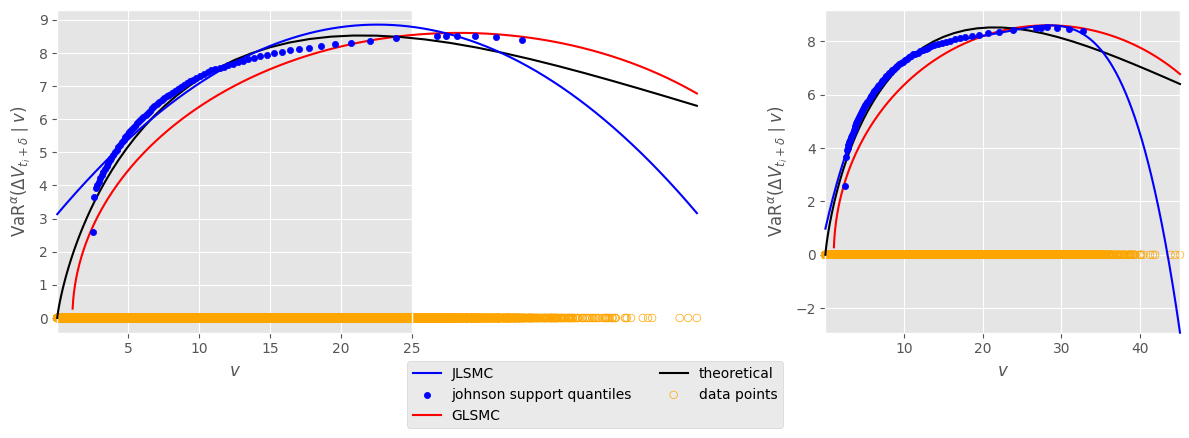

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(mtm_func, varhat_func_jlsmc, color=color_jlsmc, zorder=4, clip_on=False, label='JLSMC')
axs[0].scatter(mtm_supp, quanthat_supp_jlsmc, color=color_jlsmc, s=20, zorder=5, clip_on=False, label='johnson support quantiles')
axs[0].plot(mtm_func[mask_mu2hat_func_glsmc], varhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3, clip_on=False)
axs[0].plot(mtm_test, var_test, color='black', label='theoretical', zorder=3, clip_on=False)
axs[0].scatter(mtm_train, np.zeros_like(mtm_train), color='orange', s=30, zorder=1, clip_on=False, facecolors='none', label='data points')
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t_i+\\delta} \\mid v)$')
#axs[0].set_xlim(np.min(mtm_test), 25)
#axs[0].set_yticks(np.arange(0, 10, 1))
#axs[0].set_ylim(bottom=np.min(varhatbis_func_jlsmc))

axs[1].plot(mtm_func, varhatbis_func_jlsmc, color=color_jlsmc, zorder=4, clip_on=False, label='JLSMC')
axs[1].scatter(mtm_supp, quanthat_supp_jlsmc, color=color_jlsmc, s=20, zorder=5, clip_on=False)
axs[1].plot(mtm_func[mask_mu2hat_func_glsmc], varhat_func_glsmc, color=color_glsmc, label='GLSMC', zorder=3, clip_on=False)
axs[1].plot(mtm_test, var_test, color='black', label='theoretical', zorder=3, clip_on=False)
axs[1].scatter(mtm_train, np.zeros_like(mtm_train), color='orange', s=30, zorder=1, clip_on=False, facecolors='none')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t_i+\\delta} \\mid v)$')
#axs[1].set_xlim(np.min(mtm_test), np.max(mtm_test))
axs[1].set_ylim(bottom=np.min(varhatbis_func_jlsmc))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
# plt.savefig(f'figures/var_two_orders.png', bbox_inches='tight', dpi=300)
plt.show()

In [241]:
mse_jlsmc   = np.mean((varhat_comp_jlsmc - quant_comp)**2) / np.mean((quant_comp)**2)
print(f'normalized MSE JLSMC        : {mse_jlsmc:.4f}')
mse_glsmc   = np.mean((varhat_comp_glsmc - quant_comp)**2) / np.mean((quant_comp)**2)
print(f'normalized MSE GLSMC        : {mse_glsmc:.4f}')
ratio_mse   = mse_glsmc / mse_jlsmc
print(f'ratio MSE GLSMC vs JLSMC    : {ratio_mse:.4f}')

normalized MSE JLSMC        : 0.0250
normalized MSE GLSMC        : 0.2812
ratio MSE GLSMC vs JLSMC    : 11.2631


## <span id="section-5" style="color:#00B8DE"> V - Additional Statistical Verifications </span>

In [242]:
alpha_qq                                    = np.linspace(0.001, 0.999, 1000)
qq_quanthat_ref_jlsmc, mask_hat_ref_johnson = quantile_johnson(jparamshat_ref, jtypehat_ref, alpha_qq)
qq_quanthat_ref_glsmc                       = quantile_gaussian(mu2hat_ref_glsmc, alpha_qq)

In [243]:
pvalad_ref      = normal_ad(mtmdiff_ref[0])[1]
pvalhat_ksn_ref = kstest(mtmdiff_ref[0], 'norm', args=(0, np.sqrt(mu2hat_ref_glsmc[0]))).pvalue


print(f'pval AD (normal): {pvalad_ref:.4%}')
print(f'pval KS (normal): {pvalhat_ksn_ref:.4%}')

pval AD (normal): 0.0000%
pval KS (normal): 0.0000%


In [244]:
jparams_ref, jtype_ref, _   = f_johnson_M(mu1raw_ref[0], np.sqrt(mu2_ref[0]), skew_ref[0], kurt_ref[0])
jtype_ref = jtypes_map[jtype_ref]
if jtype_ref == 1:
    jparams_ref_mle = lognorm.fit(mtmdiff_ref[0])
elif jtype_ref == 2:
    jparams_ref_mle = johnsonsu.fit(mtmdiff_ref[0])
elif (jtype_ref==3) or (jtype_ref==5):
    jparams_ref_mle = johnsonsb.fit(mtmdiff_ref[0])
elif jtype_ref == 4:
    jparams_ref_mle = norm.fit(mtmdiff_ref[0])

print(f'Johnson params from nested MC moments and MLE   ({rev_jtypes_map[jtype_ref]}) : ({jparams_ref_mle[0]:.2f}, {jparams_ref_mle[1]:.2f}, {jparams_ref_mle[2]:.2f}, {jparams_ref_mle[3]:.2f})')
print(f'Johnson params from nested MC moments and MM    ({rev_jtypes_map[jtype_ref]}) : ({jparams_ref[0]:.2f}, {jparams_ref[1]:.2f}, {jparams_ref[2]:.2f}, {jparams_ref[3]:.2f})')
print(f'Jhonson params from regressed moments and MM    ({rev_jtypes_map[jtypehat_ref[0]]}) : ({jparamshat_ref[0, 0]:.2f}, {jparamshat_ref[0, 1]:.2f}, {jparamshat_ref[0, 2]:.2f}, {jparamshat_ref[0, 3]:.2f})')

Johnson params from nested MC moments and MLE   (SB) : (3.83, 2.58, -6.44, 33.67)
Johnson params from nested MC moments and MM    (SB) : (4.09, 2.66, -6.57, 35.84)
Jhonson params from regressed moments and MM    (SU) : (-0.68, 2.03, -1.33, 3.48)


In [245]:
def pval_ks_johnson(mtm, jparams, jtype):
    if jtype == 1:
        return kstest(mtm, 'lognorm', args=(1/jparams[1], jparams[2], exp(-jparams[0]/jparams[1]))).pvalue
    elif jtype == 2:
        return kstest(mtm, 'johnsonsu', args=(jparams[0], jparams[1], jparams[2], jparams[3])).pvalue
    elif (jtype==3) or (jtype==5):
        return kstest(mtm, 'johnsonsb', args=(jparams[0], jparams[1], jparams[2], jparams[3])).pvalue
    elif jtype == 4:
        return kstest(mtm, 'norm', args=(jparams[2], jparams[3])).pvalue
    
pvalhat_ksj_ref     = pval_ks_johnson(mtmdiff_ref[0], jparamshat_ref[0], jtypehat_ref[0])
pval_ksj_ref        = pval_ks_johnson(mtmdiff_ref[0], jparams_ref, jtype_ref)
pval_ksj_ref_mle    = pval_ks_johnson(mtmdiff_ref[0], jparams_ref_mle, jtype_ref)

print(f'pval KS from nested MC moments and MLE  ({rev_jtypes_map[jtype_ref]}) : {(pval_ksj_ref_mle):.2%}')
print(f'pval KS from nested MC moments and MM   ({rev_jtypes_map[jtype_ref]}) : {(pval_ksj_ref):.2%}')
print(f'pval KS from regressed moments and MM   ({rev_jtypes_map[jtypehat_ref[0]]}) : {(pvalhat_ksj_ref):.2%}')

pval KS from nested MC moments and MLE  (SB) : 72.17%
pval KS from nested MC moments and MM   (SB) : 79.98%
pval KS from regressed moments and MM   (SU) : 0.00%


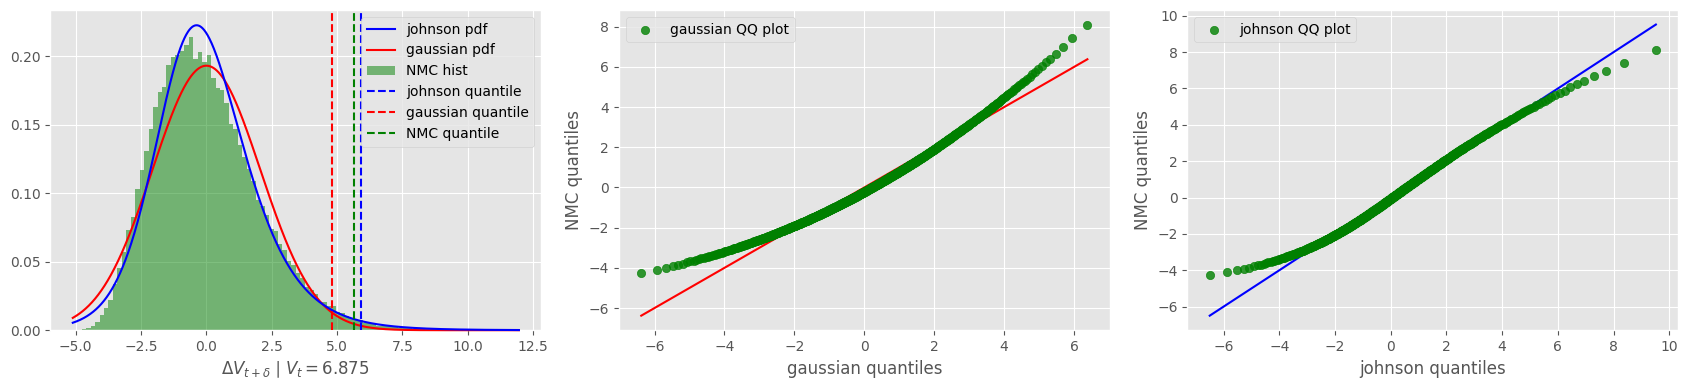

In [246]:
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

axs[0].plot(mtmdiff_pdf_ref, pdfhat_ref_jlsmc[0], color=color_jlsmc, label='johnson pdf', zorder=4, clip_on=False)
axs[0].plot(mtmdiff_pdf_ref, pdfhat_ref_glsmc[0], color=color_glsmc, label='gaussian pdf', zorder=3, clip_on=False)
axs[0].hist(mtmdiff_ref[0], bins=100, density=True, color='green', alpha=0.5, label='NMC hist', zorder=1, clip_on=False)

axs[0].axvline(x=quanthat_ref_jlsmc, color=color_jlsmc, linestyle='--', label='johnson quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quanthat_ref_glsmc, color=color_glsmc, linestyle='--', label='gaussian quantile', zorder=5, clip_on=False)
axs[0].axvline(x=quant_ref, color='green', linestyle='--', label='NMC quantile', zorder=4, clip_on=False)
axs[0].set_xlabel('$\\Delta V_{t+\\delta} \\mid V_t = 6.875$ ')
axs[0].legend()

axs[1].plot(qq_quanthat_ref_glsmc[0], qq_quanthat_ref_glsmc[0], color=color_glsmc, zorder=3, clip_on=False)
axs[1].scatter(qq_quanthat_ref_glsmc[0], np.quantile(mtmdiff_ref[0], alpha_qq, method='inverted_cdf'), color='green', label='gaussian QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[1].set_xlabel('gaussian quantiles')
axs[1].set_ylabel('NMC quantiles')
axs[1].legend()

axs[2].plot(qq_quanthat_ref_jlsmc[0], qq_quanthat_ref_jlsmc[0], color=color_jlsmc, zorder=3, clip_on=False)
axs[2].scatter(qq_quanthat_ref_jlsmc[0], np.quantile(mtmdiff_ref[0], alpha_qq, method='inverted_cdf'), color='green', label='johnson QQ plot', alpha=0.8, zorder=3, clip_on=False)
axs[2].set_xlabel('johnson quantiles')
axs[2].set_ylabel('NMC quantiles')
axs[2].legend()

plt.tight_layout()
# plt.savefig(f'figures/pdf_qq.png', bbox_inches='tight', dpi=300)
plt.show()

In [247]:
'''
phitter_cont = phitter.Phitter(mtmdiff_ref[0])
phitter_cont.fit()
df = phitter_cont.df_sorted_distributions_sse
df.head(5)
'''

'\nphitter_cont = phitter.Phitter(mtmdiff_ref[0])\nphitter_cont.fit()\ndf = phitter_cont.df_sorted_distributions_sse\ndf.head(5)\n'

## <span id="section-6" style="color:#00B8DE"> VI - Forward IM Profile </span>

In [248]:
Nnmc        = 2
Mnmc        = 200
inds_nmc    = np.linspace(0, len(time_grid[:-ind_delta]) - 1, num=Nnmc, dtype=int)
count_nmc   = 0

varhat_train_full_jlsmc = np.zeros_like(mtmdiff_paths)
varhat_train_full_glsmc = np.zeros_like(mtmdiff_paths)
varhat_train_full_nmc   = np.zeros((mtmdiff_paths.shape[0], len(inds_nmc)))
var_train_full          = np.zeros_like(mtmdiff_paths)
for t in tqdm(range(mtmdiff_paths.shape[1])):
    S_train         = S_paths[:, t]
    mtm_train       = mtm_paths[:, t]
    mtm_supp        = np.quantile(mtm_train, q_all, method='inverted_cdf')
    y_train_jlsmc   = mtmdiff_paths[:, t:t+1]**np.arange(1, order_mom+1)
    y_train_glsmc   = mtmdiff_paths[:, t]**2

    yhat_pred_list_jlsmc = regress_moms_jlsmc(mtm_train, y_train_jlsmc, [mtm_supp])
    yhat_pred_list_glsmc = regress_moms_glsmc(mtm_train, y_train_glsmc, [mtm_train])

    mu1rawhat_supp_jlsmc, _, _, _, mu2hat_supp_jlsmc, _, _, skewhat_supp_jlsmc, kurthat_supp_jlsmc, _, _, _, _, _, mask_tothat_supp_jlsmc   = get_moms_mask(yhat_pred_list_jlsmc[0])
    _, _, _, _, mu2hat_train_glsmc, _, _, _, _, mask_mu2hat_train_glsmc, _, _, _, _, _                                                      = get_moms_mask(yhat_pred_list_glsmc[0])

    jparamshat_supp, jtypehat_supp, mask_hat_supp_jlsmc = fit_johnson(mu1rawhat_supp_jlsmc, mu2hat_supp_jlsmc, skewhat_supp_jlsmc, kurthat_supp_jlsmc, mask_tothat_supp_jlsmc, False)
    jparamshat_supp, jtypehat_supp, mtm_supp            = jparamshat_supp[mask_hat_supp_jlsmc], jtypehat_supp[mask_hat_supp_jlsmc], mtm_supp[mask_hat_supp_jlsmc]

    quanthat_supp_jlsmc, mask_hat_supp_johnson  = quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([alpha]))
    mtm_supp, quanthat_supp_jlsmc               = mtm_supp[mask_hat_supp_johnson.reshape(-1)], quanthat_supp_jlsmc[mask_hat_supp_johnson]
    varhat_train_jlsmc                          = get_var_jlsmc(R_jlsmc, mtm_supp, quanthat_supp_jlsmc, [mtm_train])[0]

    varhat_train_glsmc                          = np.nan * np.ones_like(mtm_train)
    varhat_train_glsmc[mask_mu2hat_train_glsmc] = quantile_gaussian(mu2hat_train_glsmc[mask_mu2hat_train_glsmc], alpha).reshape(-1)

    varhat_train_full_jlsmc[:, t]   = varhat_train_jlsmc.reshape(-1)
    varhat_train_full_glsmc[:, t]   = varhat_train_glsmc
    var_train_full[:, t]            = gen_var_put(S_train, mtm_train)

    '''
    if t==inds_nmc[count_nmc]:
        
        start_nmc = time()
        if t==0:
            _, mtmdiff_nmc, _, _, _, _, _, _, _, _, _ = get_moms_nmc(Mnmc, S_train[0:1], t)
        else:
            _, mtmdiff_nmc, _, _, _, _, _, _, _, _, _ = get_moms_nmc(Mnmc, S_train, t)
        varhat_train_full_nmc[:, count_nmc] = np.quantile(mtmdiff_nmc, alpha, axis=1)
        count_nmc += 1
        end_nmc = time()
        print(f'Processed NMC point {count_nmc}/{Nnmc} at time {time_grid[t]:.4f} in {end_nmc - start_nmc:.2f} s')
    '''
    

100%|██████████| 230/230 [01:13<00:00,  3.13it/s]


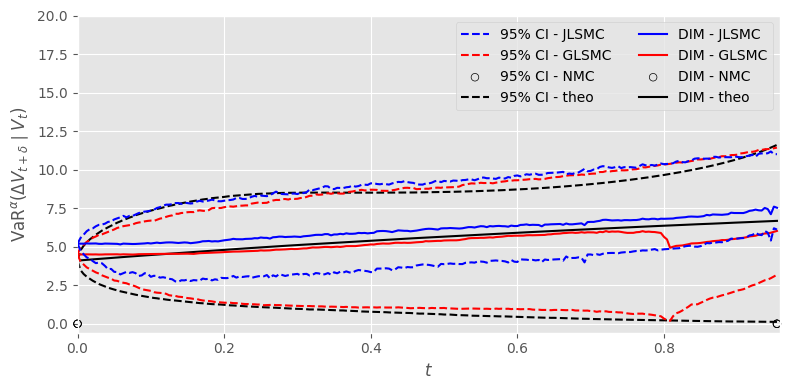

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(time_grid[:-ind_delta], np.quantile(varhat_train_full_jlsmc, 0.975, axis=0), linestyle='--', color=color_jlsmc, label='95% CI - JLSMC', zorder=4)
ax.plot(time_grid[:-ind_delta], np.nanquantile(varhat_train_full_glsmc, 0.975, axis=0), linestyle='--', color=color_glsmc, label='95% CI - GLSMC', zorder=3)
ax.scatter(time_grid[:-ind_delta][inds_nmc], np.quantile(varhat_train_full_nmc, 0.975, axis=0), color='black', s=30, facecolors='none', label='95% CI - NMC', clip_on=False, zorder=1)
ax.plot(time_grid[:-ind_delta], np.quantile(var_train_full, 0.975, axis=0), linestyle='--', color='black', label='95% CI - theo', zorder=2)

ax.plot(time_grid[:-ind_delta], np.mean(varhat_train_full_jlsmc, axis=0), color=color_jlsmc, label='DIM - JLSMC', zorder=4)
ax.plot(time_grid[:-ind_delta], np.nanmean(varhat_train_full_glsmc, axis=0), color=color_glsmc, label='DIM - GLSMC', zorder=3)
ax.scatter(time_grid[:-ind_delta][inds_nmc], np.mean(varhat_train_full_nmc, axis=0), color='black', s=30, facecolors='none', label='DIM - NMC', clip_on=False, zorder=1)
ax.plot(time_grid[:-ind_delta], np.mean(var_train_full, axis=0), color='black', label='DIM - theo', zorder=2)

ax.plot(time_grid[:-ind_delta], np.quantile(varhat_train_full_jlsmc, 0.025, axis=0), linestyle='--', color=color_jlsmc, zorder=4)
ax.plot(time_grid[:-ind_delta], np.nanquantile(varhat_train_full_glsmc, 0.025, axis=0), linestyle='--', color=color_glsmc, zorder=3)
ax.scatter(time_grid[:-ind_delta][inds_nmc], np.quantile(varhat_train_full_nmc, 0.025, axis=0), color='black', s=30, facecolors='none', clip_on=False, zorder=1)
ax.plot(time_grid[:-ind_delta], np.quantile(var_train_full, 0.025, axis=0), linestyle='--', color='black', zorder=2)

ax.set_xlabel('$t$')
ax.set_ylabel('$\\text{VaR}^\\alpha(\\Delta V_{t+\\delta} \\mid V_t)$')
ax.set_xlim(np.min(time_grid[:-ind_delta]), np.max(time_grid[:-ind_delta])+dt)
ax.set_ylim(top=20)
ax.legend(ncol=2)
plt.tight_layout()

plt.show()